![SIIM21](SIIM-2021.png "SIIM21")

# Simple Binary Classifier using Keras

## SIIM Github Repo

### Task 

Train a deep learning model to classify sagittal T1 MRI sequences into pre- or post-contrast.

### Requirements

1. Basic understanding of machine learning and deep learning
2. Programming in Python

### Learning objectives

At the end of this activity, you will be able to:

1. Understand how to organize your data to use it to train a deep learning model
2. Use the standard data handler from Keras (DataGenerator) to access your dataset to train a model
3. Create a custom convolutional neural network
4. Train a model
5. Calculate metrics in the Validation and Test sets


### Acknowledgements

This Jupyter Notebook was based on code by Paulo Eduardo de Aguiar Kuriki (paulokuriki@gmail.com), modified by Felipe Kitamura (kitamura.felipe@gmail.com).

## Dataset Format

First of all, we need to split out images into training, validation and test sets

For this task, we have a separate test folder and a training folder. The training folder will be split into training and validation by our code.

The files are organized in the following folder structure:

#### Train/with_gad/ - contains the files of sequences with contrast

#### Train/no_gad/ - contains the files of sequences without contrast

#### Test/with_gad/ - contains the files of sequences with contrast

#### Test/no_gad/ - contains the files of sequences without contrast

First thing we need to do is to download the dataset from these two links (https://drive.google.com/file/d/1rffWXRBaePSo7JMwJm1ygDdpgs7FZuTi/view?usp=sharing, https://drive.google.com/file/d/1x4LTeyPgLNndsP8w0rtn-pCV0LzOVc1H/view?usp=sharing). If you are using colab, you will need to upload this dataset to colab. If you are running your notebook locally, then you just need to copy theTrain.zip and Test.zip files to the same folder where you are running this notebook.

Then we unzip our dataset, by running the following cell.

In [1]:
!unzip Train.zip
!unzip Test.zip

# This cell just needs to be run once. 
# After running it, you can comment it by adding # as the first character in the two first lines.

## Importing the libraries we will need

In [2]:
import sys
from matplotlib import pyplot
import numpy as np

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.random import set_seed
from tensorflow.keras.activations import sigmoid
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
import itertools

#This command makes only 1 GPU visible to our code, in case we have multiple GPUs.
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# To have reproducible results, it is important to set the seed for all tensorflow functions
set_seed(1020)

## Defining the variables we will use

In [3]:
# Configure variables


# Here we define the folders where our dataset is saved.
TRAIN_DATA_DIR = r'Train/'
TEST_DATA_DIR = r'Test/'

# Here we define the input size of our neural network.
# Images will be resized automatically.
IMG_HEIGHT = 331
IMG_WIDTH = 331

# Here we define the size of the Batch to leverage
# the capacity GPUs have to parallelize 
BATCH_SIZE = 64

## Defining a function to plot the learning curves

In [4]:
# This function plots the learning curves, which includes
# the loss curve and the accuracy curve over the epochs.
def plot_learning_curves(history):
    # plot loss
    pyplot.figure(figsize=(10, 5))
    pyplot.title('Binary Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='Train')
    pyplot.plot(history.history['val_loss'], color='orange', label='Validation')
    pyplot.legend(loc='upper right', shadow=True, fontsize='x-large')
    pyplot.show()
    # plot accuracy
    pyplot.figure(figsize=(10, 5))
    pyplot.title('Binary Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='Train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='Validation')
    pyplot.legend(loc='lower right', shadow=True, fontsize='x-large')
    pyplot.show()

## Creating a custom convolutional neral network

In [5]:
# Every model needs to have an input
x1 = Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))

# Below, we add paired convolutional and maxpooling layers
x = Conv2D(16, (3,3), activation='relu')(x1)
x = MaxPooling2D()(x)
x = Conv2D(16, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)

# Then we flatten the last vector
flat1 = Flatten()(x)
# Insert a dropout layer with 20% probability
flat2 = Dropout(0.2)(flat1)
# Then a dense layer
class1 = Dense(64, activation='relu', kernel_initializer='he_uniform')(flat2)
# And the output layer
class1b = Dense(1, activation='linear')(class1)
# The output needs to be binary, so we apply a sigmoid function
output = sigmoid(class1b)

# Here is where the model is created based on the input and output define above
model = Model(inputs=x1, outputs=output)

# We choose an optimizer
opt = Adam(lr=0.0005)

# The last step is to compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# We can see the structure and number of parameter of our network
# by calling .summary()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 329, 329, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 164, 164, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 162, 162, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 81, 81, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 79, 79, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 39, 39, 32)        0     

## Now we create a Data Generator, which is a function to read the images from the folders and use them to train and validate

In [6]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   #horizontal_flip=False,
                                   #vertical_flip=True,
                                   #rotation_range=0,
                                   #fill_mode='constant',
                                   #cval=0,
                                   #preprocessing_function=preprocess_input,
                                   validation_split=0.2)  # set validation split

train_it = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    subset='training')  # set as training data

val_it = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,  # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    subset='validation')  # set as validation data

Found 722 images belonging to 2 classes.
Found 179 images belonging to 2 classes.


## Show time. This is the moment we train our network

Epoch 1/15
12/12 [==============================] - 8s 430ms/step - loss: 0.6534 - accuracy: 0.6738 - val_loss: 0.5671 - val_accuracy: 0.7709
Epoch 2/15
12/12 [==============================] - 4s 384ms/step - loss: 0.5426 - accuracy: 0.7777 - val_loss: 0.5193 - val_accuracy: 0.7709
Epoch 3/15
12/12 [==============================] - 4s 369ms/step - loss: 0.5514 - accuracy: 0.7354 - val_loss: 0.4766 - val_accuracy: 0.7709
Epoch 4/15
12/12 [==============================] - 4s 366ms/step - loss: 0.4334 - accuracy: 0.7818 - val_loss: 0.3301 - val_accuracy: 0.7989
Epoch 5/15
12/12 [==============================] - 4s 367ms/step - loss: 0.2901 - accuracy: 0.8769 - val_loss: 0.1851 - val_accuracy: 0.9497
Epoch 6/15
12/12 [==============================] - 4s 366ms/step - loss: 0.1962 - accuracy: 0.9266 - val_loss: 0.1057 - val_accuracy: 0.9721
Epoch 7/15
12/12 [==============================] - 4s 364ms/step - loss: 0.1201 - accuracy: 0.9556 - val_loss: 0.0959 - val_accuracy: 0.9721
Epoch 

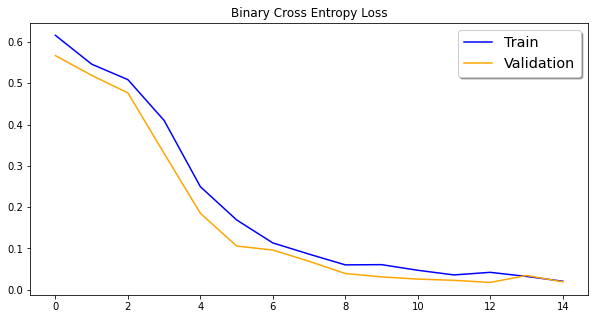

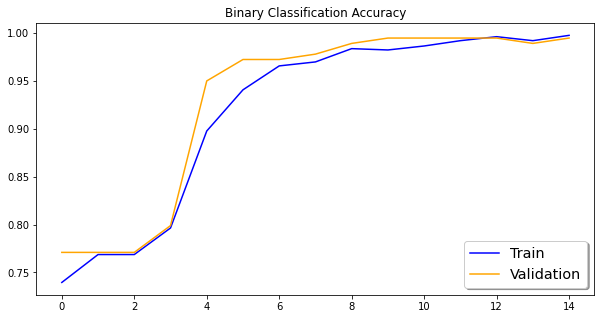

In [7]:

# The .fit() method is used to train our network
# You can specify here the number os epochs
history = model.fit(train_it, steps_per_epoch=len(train_it), 
                              validation_data=val_it, validation_steps=len(val_it), 
                              epochs=15, verbose=1)

plot_learning_curves(history)

You should expect curves showing decreasing losses and increasing accuracies for both training and validation sets

## We can save our trained model in a file so we can restore it to be used later

In [8]:
# To save your model, uncomment the following line and run this cell.

#model.save('SimpleGadClass.h5')

## The following line allows us to read the model we trained

In [9]:
# Make sure the file name you try to read from is the same you saved

model = load_model('SimpleGadClass.h5')

## Here we predict the validation set so we can use both predictions and ground truth to calculate the performance metrics

In [10]:
i=0
y_true = []
y_pred = []
x_test = []

for x, y in val_it:
    y_true.extend(y)
    y_pred.extend(model.predict(x))
    x_test.extend(x)
    i+=1
    if i==len(val_it):
        break

y_pred = np.asarray(y_pred)
x_test = np.asarray(x_test)

## Now we plot the ROC curve for the validation set

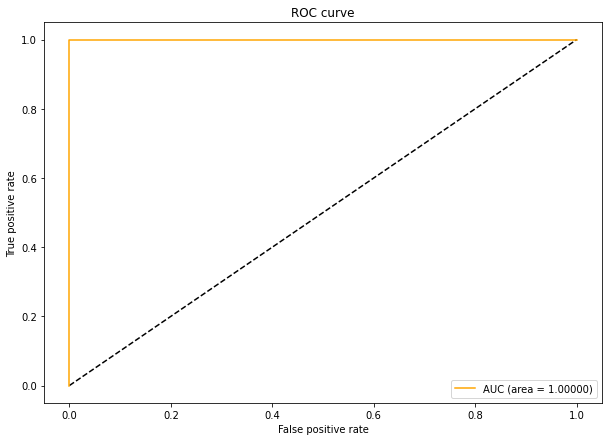

In [11]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)

auc_keras = auc(fpr_keras, tpr_keras)

pyplot.figure(figsize=(10,7))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr_keras, tpr_keras, label='AUC (area = {:.5f})'.format(auc_keras), color='orange')
pyplot.xlabel('False positive rate')
pyplot.ylabel('True positive rate')
pyplot.title('ROC curve')
pyplot.legend(loc='best')
pyplot.show()

## Now we plot the confusion matrix for the validation set

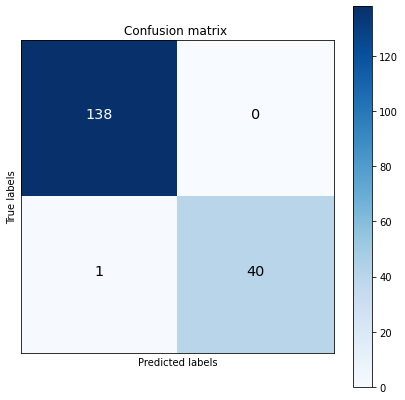

In [12]:
thresh = 0.5
cm = confusion_matrix(y_true, y_pred > thresh)

pyplot.figure(figsize=(7,7))
pyplot.imshow(cm, cmap=pyplot.cm.Blues)
pyplot.xlabel("Predicted labels")
pyplot.ylabel("True labels")
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    pyplot.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 120 else "black", size='x-large')
pyplot.xticks([], [])
pyplot.yticks([], [])
pyplot.title('Confusion matrix ')
pyplot.colorbar()
pyplot.show()

## Here we predict the test set so we can use both predictions and ground truth to calculate the performance metrics

In [13]:
ext_val_datagen = ImageDataGenerator(rescale=1. / 255,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   #horizontal_flip=False,
                                   #vertical_flip=True,
                                   #rotation_range=0,
                                   #fill_mode='constant',
                                   #cval=0,
                                   #preprocessing_function=preprocess_input,
                                   )  # set validation split

ext_val_it = ext_val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb')  # set as training data

Found 571 images belonging to 2 classes.


In [14]:
i=0
y_true = []
y_pred = []
x_test = []

for x, y in ext_val_it:

    y_true.extend(y)
    y_pred.extend(model.predict(x))
    x_test.extend(x)
    i+=1
    if i==len(ext_val_it):
        break

y_pred = np.asarray(y_pred)
x_test = np.asarray(x_test)

## Now we plot the ROC curve for the test set

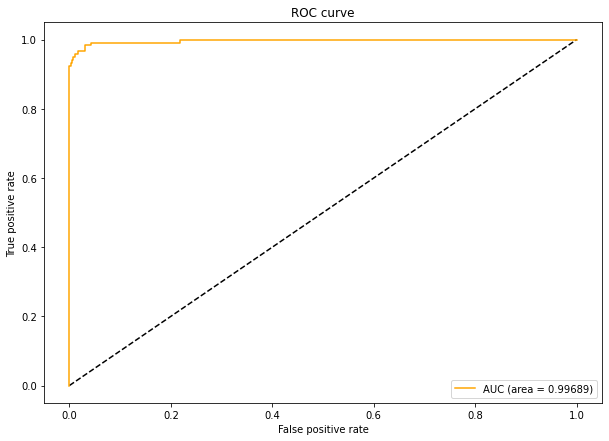

In [15]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)

auc_keras = auc(fpr_keras, tpr_keras)

pyplot.figure(figsize=(10,7))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr_keras, tpr_keras, label='AUC (area = {:.5f})'.format(auc_keras), color='orange')
pyplot.xlabel('False positive rate')
pyplot.ylabel('True positive rate')
pyplot.title('ROC curve')
pyplot.legend(loc='best')
pyplot.show()

## Now we find the threshold with the best accuracy

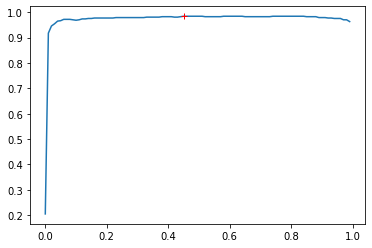

In [16]:
thr_list = []
acc_list = []
for _th in range(100):
    _th = _th / 100.
    thr_list.append(_th)
    acc_list.append(accuracy_score(y_true, y_pred > _th))

pyplot.figure()
pyplot.plot(thr_list,acc_list)
pyplot.plot(thr_list[acc_list.index(max(acc_list))], max(acc_list), 'r+')

pyplot.show()

## Now we plot the ROC curve for the test set

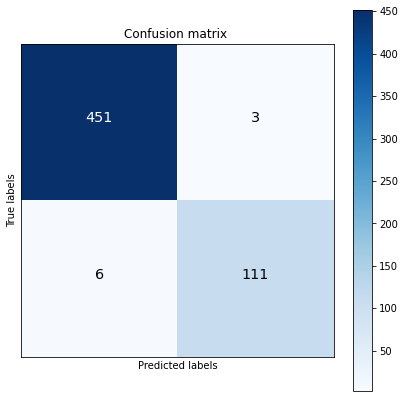

In [17]:
thresh = thr_list[acc_list.index(max(acc_list))]
cm = confusion_matrix(y_true, y_pred > thresh)

pyplot.figure(figsize=(7,7))
pyplot.imshow(cm, cmap=pyplot.cm.Blues)
pyplot.xlabel("Predicted labels")
pyplot.ylabel("True labels")
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    pyplot.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 120 else "black", size='x-large')
pyplot.xticks([], [])
pyplot.yticks([], [])
pyplot.title('Confusion matrix ')
pyplot.colorbar()
pyplot.show()

## Finally, we plot cases that our model predicted incorrectly so we can understand the errors an try to come up with solutions

Truth:1.0
Pred:0.042914335
134


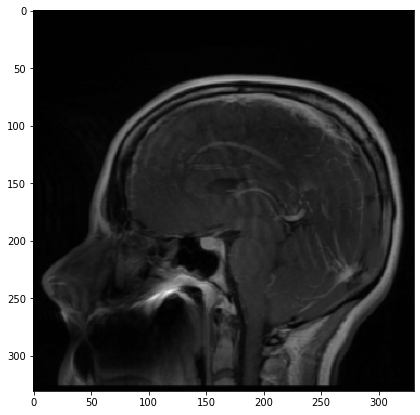

Truth:0.0
Pred:0.5324932
258


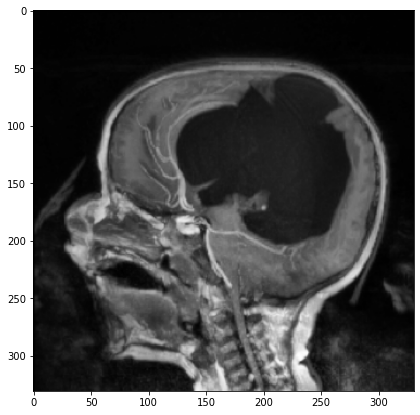

Truth:0.0
Pred:0.57260007
269


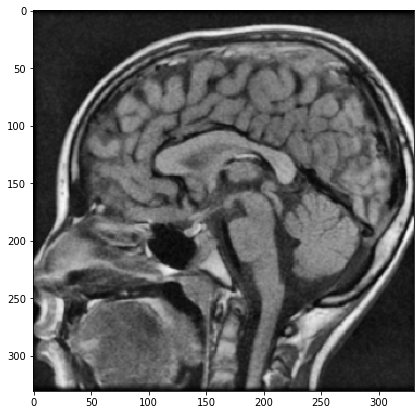

Truth:1.0
Pred:0.0983339
355


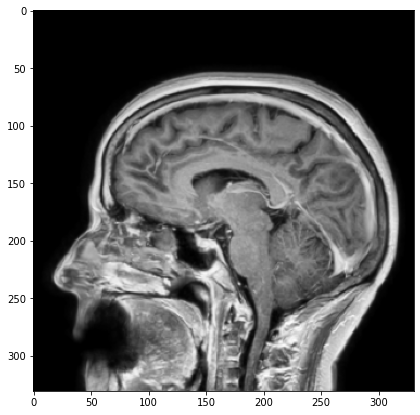

Truth:1.0
Pred:0.41690472
429


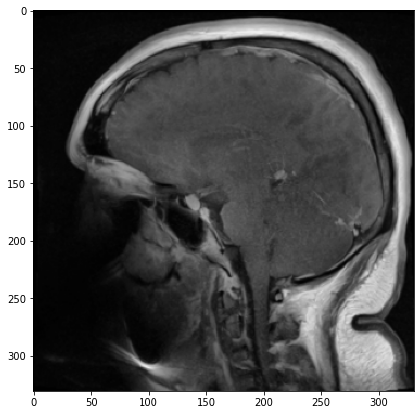

Truth:1.0
Pred:0.08665635
483


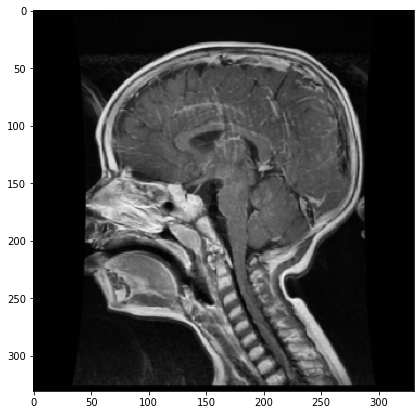

Truth:1.0
Pred:0.0024333133
492


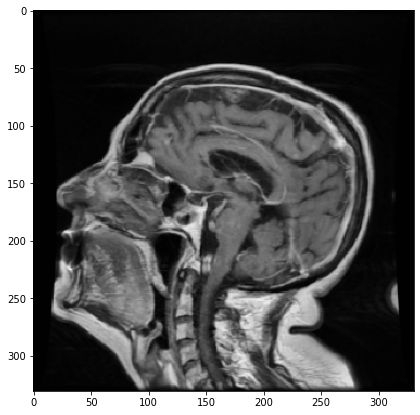

Truth:0.0
Pred:0.73249173
559


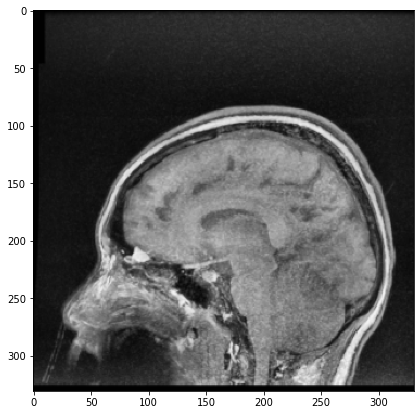

Truth:1.0
Pred:0.1573414
570


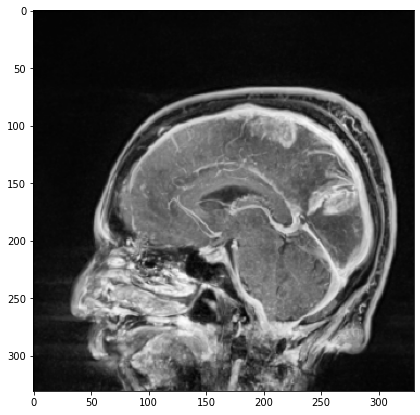

In [18]:
for i in range(len(y_true)):
    if y_true[i] != 1. * (y_pred[i, 0] > thresh):
        print('Truth:' + str(y_true[i]))
        print('Pred:' + str(y_pred[i, 0]))
        print(i)
        pyplot.figure(figsize=(7,7))
        pyplot.imshow(x_test[i])
        pyplot.show()